# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python


tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


In [2]:
from collections import deque, namedtuple
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import time
import torch
from torch.autograd import Variable
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment
# from utilities import hard_update, gumbel_softmax, onehot_from_logits, soft_update, transpose_to_tensor,\
#         transpose_list
from workspace_utils import active_session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
# from unityagents import UnityEnvironment
# import numpy as np

# env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents 
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
# for i in range(5):                                         # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
# create the multi-arm environment
env = UnityEnvironment(file_name='/data/Tennis_Linux_NoVis/Tennis', no_graphics = True)

# create the brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get the basic environment info
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


## This solution drew initially from the following:
* My solutions from Project 1 and 2
* The MADDPG Udacity sample
* https://github.com/nikhilmasinete/Compete_and_Colloborate
* https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
* https://github.com/KailinTong/Udacity-Project-1-Navigation/blob/main/dqn_agent.py


In [12]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

        
    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        
        return self.state
    

In [13]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    # Expand layers and layer size from DDPG project
    def __init__(self, state_size, action_size, fc1_units, fc2_units, fc3_units, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)  # Add batch normalization per the DDPG paper part 3
        self.do = nn.Dropout(0.25)  # Add dropout
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        self.fc1.bias.data.fill_(0.1)
        self.fc2.bias.data.fill_(0.1)
        self.fc3.bias.data.fill_(0.1)
        self.fc4.bias.data.fill_(0.1)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        # Add batch normalization per the DDPG paper part 3
        x = F.relu(self.bn1(self.fc1(state)))
        x = self.do(x)  # Add dropout
        x = F.relu(self.fc2(x))
        x = self.do(x)  # Add dropout
        x = F.relu(self.fc3(x))
        x = self.do(x)  # Add dropout
        
        return F.tanh(self.fc4(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    # Expand layer size from DDPG project
    def __init__(self, state_size, action_size, fc1_units, fc2_units, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        # The input is the states and actions for all agents
        self.fc1 = nn.Linear((state_size + action_size) * num_agents, fc1_units)
        # Add batch normalization per the DDPG paper part 3
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.do = nn.Dropout(0.25)  # Add dropout
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc1.bias.data.fill_(0.1)
        self.fc2.bias.data.fill_(0.1)
        self.fc3.bias.data.fill_(0.1)


    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        inputs = torch.cat((state, action.float()), dim = 1)
        # Add batch normalization per the DDPG paper part 3
        x = F.leaky_relu(self.bn1(self.fc1(inputs)))
        x = self.do(x)  # Add dropout
        x = F.leaky_relu(self.fc2(x))
        x = self.do(x)  # Add dropout
        
        return self.fc3(x)


In [15]:
class SumTree:
    """
    A faster data structure for prioritized sampling.
    
    Reference code:
    https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
    https://github.com/KailinTong/Udacity-Project-1-Navigation/blob/main/dqn_agent.py
    """

    data_pointer = 0
    overflow = False

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        # [--------------Parent nodes-------------][-------leaves to recode priority-------]
        #             size: capacity - 1                       size: capacity
        self.data = np.zeros(capacity, dtype=object)  # for all transitions
        # dtype=object means that the array fills with pointers to python objects
        # [--------------data frame-------------]
        #             size: capacity
        self.size = 0

    def add(self, p, data):
        """
        Args:
            p: priority value
            data: state transition tuple
        """
        tree_idx = self.data_pointer + self.capacity - 1  # populate leaves bottom to top
        self.data[self.data_pointer] = data  # add the experience
        self.update(tree_idx, p)  # update the leaf values

        self.size += 1
        
        self.data_pointer += 1  # move to next leaf position
        if self.data_pointer >= self.capacity:  # replace populated leaves once past capacity
            self.data_pointer = 0  # reset the leaf position to bottom child
            self.overflow = True
            print("Sum tree memory overflow!")

    def update(self, tree_idx, p):
        """
        update the node priority through the tree
        Args:
            tree_idx: tree index
            p: priority
        """
        change = p - self.tree[tree_idx]  # compute the amount to update parents
        self.tree[tree_idx] = p  # set value of leaf
        while tree_idx != 0:  # propagate the change up the tree, until reaching the root
            tree_idx = (tree_idx - 1) // 2  # select parent leaf
            self.tree[tree_idx] += change  # increase the parent leaf value

    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for transitions
        Array type for storing:
        [0,1,2,3,4,5,6]
        Args:
            v: priority value
        Returns:
            leaf_idx, self.tree[leaf_idx], self.data[data_idx]
        """
        parent_idx = 0  # start searching at top
        while True:
            cl_idx = 2 * parent_idx + 1  # left child of leaf
            cr_idx = cl_idx + 1  # right child of leaf
            if cl_idx >= len(self.tree):  # reached bottom, end search
                leaf_idx = parent_idx
                break
            else:  # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx]:
                    parent_idx = cl_idx  # branch left
                else:
                    v -= self.tree[cl_idx]  # adjust priority value
                    parent_idx = cr_idx  # branch right

        data_idx = leaf_idx - self.capacity + 1  # get position of experience
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_p(self):
        return self.tree[0]  # the root
    

In [16]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, num_agents, seed, e_stab, a_ext, per):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names =\
                                     ["states", "actions", "rewards", "next_states", "dones"])
        self.seed = random.seed(seed)
        self.e_stab = e_stab
        self.a_ext = a_ext
        self.per = per
        self.num_agents = num_agents
        self.abs_err_upper = np.float(1)  # clipped abs error
        
        if per:
            self.memory = SumTree(capacity = buffer_size)      
        else:
            self.memory = deque(maxlen = buffer_size)

    
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        if self.per:
            # get max probability from the child leaves which will be udpated
            max_prob = np.max(self.memory.tree[-self.memory.capacity:])
            # setting empty leaves to the clipped max ensures the agent learns...
            # ...from newly added experiences
            if max_prob == 0:
                max_prob = self.abs_err_upper
            e = self.experience(state, action, reward, next_state, done)
            self.memory.add(max_prob, e)
        else:
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)


    def update_priorities(self, errs, exp_idxs):
        """Update priorities of the experiences sampled."""
        # add small TD error offset for stability
        errs += self.e_stab  
        # clip TD errors for stability
        clipped_errs = np.minimum(errs, self.abs_err_upper)
        # Implement extent of prioritization
        raised_errs = np.power(clipped_errs, self.a_ext)  
        # update each experience, one at a time
        for idx, raised_err in zip(exp_idxs, raised_errs):
            self.memory.update(idx, raised_err)
    
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = [torch.from_numpy(np.vstack([e.states[agt] for e in experiences if e is not None])).\
                float().to(device) for agt in range(self.num_agents)]
        actions = [torch.from_numpy(np.vstack([e.actions[agt] for e in experiences if e is not None])).\
                float().to(device) for agt in range(self.num_agents)]
        rewards = [torch.from_numpy(np.vstack([e.rewards[agt] for e in experiences if e is not None])).\
                float().to(device) for agt in range(self.num_agents)]
        next_states = [torch.from_numpy(np.vstack([e.next_states[agt] for e in experiences if e is not None])).\
                float().to(device) for agt in range(self.num_agents)]
        dones = [torch.from_numpy(np.vstack([e.dones[agt] for e in experiences if e is not None]).\
                astype(np.uint8)).float().to(device) for agt in range(self.num_agents)]
        
        return (states, actions, rewards, next_states, dones)

    
    def tree_sample(self, b):
        """
        Sample a mini batch from prioritized memory,
        using a sumtree.
        """
        # initialize array of indices
        idxs = [np.empty((self.batch_size,), dtype=np.int32) for agt in range(self.num_agents)] 
        
        # initialize array of IS weights
        is_weights = [np.empty((self.batch_size, 1), dtype=np.float32) for agt in range(self.num_agents)] 

        # compute average priority (equates to sampling bin size)
        pri_seg = self.memory.total_p / self.batch_size

        
        # get max probability for IS weight stabilization
        if self.memory.overflow is False:
            max_prob = np.max(self.memory.tree[
                    -self.memory.capacity:-self.memory.capacity + self.memory.data_pointer])
        else:
            max_prob = np.max(self.memory.tree[-self.memory.capacity:])

        states, actions, rewards, next_states, dones = list(), list(), list(), list(), list()
        for agt in range(self.num_agents):
            s, a, r, ns, d = list(), list(), list(), list(), list()
            for i in range(self.batch_size):
                # The sumtree root value represents the range of values to sample.
                # Hence, we must break the range into equal sized bins, one for each sample.
                low_bd = pri_seg * i  # set lower boundary of sampling bin
                high_bd = pri_seg * (i + 1)  # set upper boundary of sampling bin
                v = np.random.uniform(low_bd, high_bd)  # sample within bin
                idx, p, data = self.memory.get_leaf(v)  # get sumtree leaf based on sample
                is_weights[agt][i, 0] = np.power(p / max_prob, -b)  # compute IS weights using stabilitzation
                idxs[agt][i] = idx

                s.append(data.states[agt])
                a.append(data.actions[agt])
                r.append(data.rewards[agt])
                ns.append(data.next_states[agt])
                d.append(data.dones[agt])

            states.append(torch.from_numpy(np.vstack(s)).float().to(device))
            actions.append(torch.from_numpy(np.vstack(a)).float().to(device))
            rewards.append(torch.from_numpy(np.vstack(r)).float().to(device))
            next_states.append(torch.from_numpy(np.vstack(ns)).float().to(device))
            dones.append(torch.from_numpy(np.vstack(d).astype(np.uint8)).float().to(device))

            is_weights[agt] = torch.from_numpy(is_weights[agt]).to(device)
            
        return (states, actions, rewards, next_states, dones), is_weights, idxs
    

    def __len__(self):
        """Return the current size of internal memory."""
        if self.per:
#             return self.memory.capacity
            return self.memory.size
        else:
            return len(self.memory)
    

In [14]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, l1, l2, l3, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Actor Networks (Local and Target)
        self.actor_local = Actor(state_size, action_size, l1, l2, l3, seed).to(device)
        self.actor_target = Actor(state_size, action_size, l1, l2, l3, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = LR_ACTOR)

        # Critic Networks (Local and Target)
        self.critic_local = Critic(state_size, action_size, l1, l2, seed).to(device)
        self.critic_target = Critic(state_size, action_size, l1, l2, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = LR_CRITIC, weight_decay = WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise(action_size, seed)

        self.t_step = 0


    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state.unsqueeze(0)).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:  # Use noise to induce exploration, per the DDPG paper part 3
            action = action + self.noise.sample()
            
        return np.clip(action, -1, 1)

    
    def reset(self):
        self.noise.reset()                   
    

In [17]:
BUFFER_SIZE = num_agents * int(1e5)  # replay buffer size
BATCH_SIZE = 256  # learning batch size
GAMMA = 0.99  # discount factor
GOAL = 0.5
B_START = 0.1
B_FACT = 1
TAU = 1e-2  # for update proportion of target parameters
LR_ACTOR = 1e-4  # learning rate of the actor 
LR_CRITIC = 1e-3  # learning rate of the critic
WEIGHT_DECAY = 0  # L2 weight decay
UDT_IVL = 1  # update interval (time steps)
UDT_RDS = 1  # update rounds (number of times to sample per agent)
SEED = 2
E_STAB = 1e-3  # a small number to ensure stability for small TD errors
A_EXT = 0.5  # The extent to which prioritization is used vs uniform sampling (1 vs 0)
L1 = 512  # layer 1 size
L2 = 256  # layer 2 size
L3 = 128  # layer 3 size


class MADDPG():
    
    def __init__(self, state_size, action_size, num_agents, gamma, tau, seed, e_stab, a_ext, per):
       
        self.num_agents = num_agents
        # setup an Agent object for each paddle
        self.maddpg = [Agent(state_size, action_size, L1, L2, L3, seed) for i in range(self.num_agents)]
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.per = per
        # setup a common replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, num_agents, seed, e_stab, a_ext, per)
        self.t_step = 0
    
    
    def act_episode(self, states):
        """
        Return actions for the given state per current policy.
        """
        actions = [agent.act(state, add_noise=True) for agent, state in zip(self.maddpg, states)]
        actions = np.array(actions).reshape((2, 2))
        
        return actions
    
    
    def act_target(self, next_states, actions, agt_num):
        """
        Get next actions according to the target actor by passing the next state, for both agents.
        """
        next_actions = [agent.actor_target(next_state) if idx == agt_num else actions[idx].clone()\
                        for idx, (agent, next_state) in enumerate(zip(self.maddpg, next_states))]
        
        return next_actions
    
    
    def act_local(self, states, actions, agt_num):
        """
        Get predicted actions according to the local actor by passing the state, for both agents.
        """
        actions_pred = [agent.actor_local(state) if idx == agt_num else actions[idx].clone() for\
                        idx, (agent, state) in enumerate(zip(self.maddpg, states))]
        
        return actions_pred
        
        
    def step(self, states, actions, rewards, next_states, b, dones):
        """
        Save experience in replay memory, and use random sample from buffer to learn.
        """
        # Save experience / reward
        self.memory.add(states, actions, rewards, next_states, dones)
        
        # Learn once every time step, in a batch for each agent...
        # ...if enough samples are available in memory.
        self.t_step = (self.t_step + 1) % UDT_IVL
        if len(self.memory) > BATCH_SIZE and self.t_step == 0:
            if self.per:  # sumtree sampling includes IS weight computation
                experiences, is_weights, exp_idxs  = self.memory.tree_sample(b)
            else:
                experiences = self.memory.sample()
                is_weights = None
                exp_idxs = None
            for _ in range(UDT_RDS):
                for agt in range(self.num_agents):
                    self.learn(experiences, is_weights, exp_idxs, agt, b)

                
    def reset(self):
        """
        Reset the noise for each agent
        """
        for agt in self.maddpg:
            agt.reset()
                
                
    def learn(self, experiences, is_weights, exp_idxs, agt_num, b):
        """
        Update policy and value parameters using given batch of experience tuples.
        """
        states, actions, rewards, next_states, dones = experiences
        agent = self.maddpg[agt_num]
        
        # Assemble states, next_states, and actions of all agents for the critic,...
        # ...according to pages 4-5 of the MADDPG paper.
        states_full = torch.cat(states, dim = 1).to(device)
        next_states_full = torch.cat(next_states, dim = 1).to(device)
        actions_full = torch.cat(actions, dim = 1).to(device)

        # ---------------------------- update critic ---------------------------- #
        # Get next actions (from actor) and Q values (from critic) from target models.
        # The targets should be detached...
        # ...since we are only computing gradients for the local networks.
        next_actions = self.act_target(next_states, actions, agt_num)
        next_actions_full = torch.cat(next_actions, dim = 1).detach()
        Q_targets_next = agent.critic_target(next_states_full, next_actions_full).detach()
        # Compute Q targets for current states (y_i)\n
        Q_targets = rewards[agt_num] + self.gamma * Q_targets_next *(1 - dones[agt_num])
        
        # Compute critic loss
        Q_expecteds = agent.critic_local(states_full, actions_full)
        
        
        # Implement experience priority
        if self.per:
            # compute the td error
            td_errs = torch.sub(Q_expecteds, Q_targets)
            # separate the absolute TD error from the computation graph
            errs = torch.abs(td_errs).cpu().detach().numpy().squeeze()
            # The computed TD errors must now be implemented in the experiences
            self.memory.update_priorities(errs, exp_idxs[agt_num]) 
            critic_loss = F.mse_loss(is_weights[agt_num] * Q_expecteds,\
                                     is_weights[agt_num] * Q_targets)
        else:
            critic_loss = F.mse_loss(Q_expecteds, Q_targets)
        
        
        # Minimize the loss
        agent.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.critic_local.parameters(), 1)
        agent.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.act_local(states, actions, agt_num)
        actions_pred_full = torch.cat(actions_pred, dim = 1).to(device)
        
        # to maximize the loss function (required for gradient ascent)...
        # ...we take the negative of the loss.
        actor_loss = -agent.critic_local(states_full, actions_pred_full).mean()
        
        # Minimize the loss
        agent.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.actor_local.parameters(), 1)
        agent.actor_optimizer.step()
        
        self.soft_update(agent.critic_local, agent.critic_target)
        self.soft_update(agent.actor_local, agent.actor_target)
        
        
    def soft_update(self, local_model, target_model):
        """
        Soft update model parameters.
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
            

In [18]:
def train():
    print_every = 10
    scores_all_deque = deque(maxlen = 100)  # the scores for computing performance
    scores_all_list = []  # the scores for pulling/plotting results
    num_episodes = 10000  
    b = B_START  # initialize b (how much IS weights affect learning)
    average_score = 0
    for episode in range(0, num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations  # get the current states
        magent.reset()  # reset the noise for each episode
        ep_scores = np.zeros(num_agents)  # initialize the scores for the episode
        while True:
            actions = magent.act_episode(states)  # select actions based on the states (both agents)
            
            env_info = env.step(actions)[brain_name]  # send all actions to the environment (both agents)
            next_states = env_info.vector_observations  # get next states (both agents)
            rewards = np.array(env_info.rewards)  # get rewards (both agents)
            dones = np.array(env_info.local_done)  # see if either agent finished
            
            ep_scores += rewards  # log score for the time step

            # b goes from a small number to 1 as the environment solves.
            # This controls how much important sampling weighs the update
            b = max(B_START, np.divide(average_score, GOAL * B_FACT))
            
            # 1x round of learning occurs at every step, for each agent.
            magent.step(states, actions, rewards, next_states, b, dones)
            
            states = next_states  # update the current states
            if np.any(dones):  # break the episode if any arm finished                            
                break
                
        ep_score = np.max(ep_scores)  # get total score for the episode
        scores_all_deque.append(ep_score)  # log episode score
        
        scores_all_list.append(ep_score)  # log episode score
        max10_score = np.max(scores_all_list[-10:])  # get scores for last 10 episodes
        average_score = np.mean(scores_all_deque)  # get average score of up to last 100 episodes
        print('\rEpisode {}\tEpisode score: {:.3f}\tAverage Score: {:.3f}\ttime: {:.3f}'.\
              format(episode, ep_score, average_score, time.time() - start_time), end="")
        if(average_score >=  0.5):
            print('\nEnvironment solved in {:d} episodes!\nMax score: {:.3f}\tAverage Score: {:.3f}'.\
                  format(episode-100, np.max(scores_all_list), average_score))
            break
        if episode % print_every == 0:
            print('\rEpisode {}\tMax10 score: {:.3f}\tAverage Score: {:.3f}\ttime: {:.3f}'.\
                  format(episode, max10_score, average_score, time.time() - start_time))
#         if time.time() - start_time > 150.0:
#             break
        torch.save(magent.maddpg[0].actor_local.state_dict(), "checkpoint_actor_agent1.pth")
        torch.save(magent.maddpg[0].critic_local.state_dict(), "checkpoint_critic_agent1.pth")
        torch.save(magent.maddpg[1].actor_local.state_dict(), "checkpoint_actor_agent2.pth")
        torch.save(magent.maddpg[1].critic_local.state_dict(), "checkpoint_critic_agent2.pth")
    return scores_all_list


Episode 0	Max10 score: 0.000	Average Score: 0.000	time: 0.10606
Episode 10	Max10 score: 0.100	Average Score: 0.009	time: 2.11616
Episode 20	Max10 score: 0.000	Average Score: 0.005	time: 4.64141
Episode 30	Max10 score: 0.090	Average Score: 0.006	time: 10.86767
Episode 40	Max10 score: 0.000	Average Score: 0.005	time: 16.31010
Episode 50	Max10 score: 0.000	Average Score: 0.004	time: 21.75554
Episode 60	Max10 score: 0.000	Average Score: 0.003	time: 27.30303
Episode 70	Max10 score: 0.000	Average Score: 0.003	time: 32.83838
Episode 80	Max10 score: 0.000	Average Score: 0.002	time: 38.37979
Episode 90	Max10 score: 0.100	Average Score: 0.003	time: 44.57978
Episode 100	Max10 score: 0.090	Average Score: 0.004	time: 50.84747
Episode 110	Max10 score: 0.100	Average Score: 0.004	time: 57.04645
Episode 120	Max10 score: 0.000	Average Score: 0.004	time: 62.73131
Episode 130	Max10 score: 0.000	Average Score: 0.003	time: 68.29999
Episode 140	Max10 score: 0.100	Average Score: 0.004	time: 74.42121
Episode 1

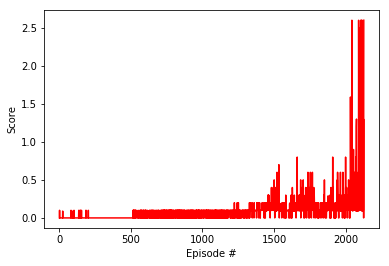

finish time: 3428.2594363689423


In [19]:
if __name__ == '__main__':
    with active_session():
        magent = MADDPG(state_size, action_size, num_agents, GAMMA, TAU, SEED,\
                        E_STAB, A_EXT, per = False)

        start_time = time.time()
        
        scores = train()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(1, len(scores)+1), scores, 'r-')
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        
        print('finish time: {}'.format(time.time() - start_time))